In [2]:
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

import math
import datetime
import random

import toy_transformer
from toy_transformer import dataset_from_file, SimpleTransformer

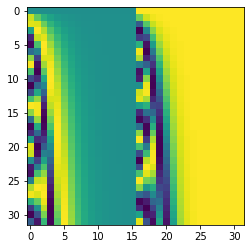

In [5]:
position_encoding = toy_transformer.make_position_encoding(sequence_size=32, dims=32)
import matplotlib.pyplot as plt
plt.imshow(position_encoding.numpy())

In [3]:
batch_size = 256
max_size = None
sequence_size = 64
num_heads = 8
layers = 6
embedding_dim = 64
position_encoding_dims = 32
feedforward_dim = 512
key_dim = 32
value_dim = 32
lr = 1e-3

# "Attention Is All You Need" paper:
#   - 6 layers
#   - embedding_dim = 512
#   - num_heads = 8
#   - key_dim = value_dim = embedding_dim / num_heads = 64
#   - feedforward_dim = 2048
# "big": embedding_dim=1024 feedforward_dim=4096 num_heads=16
"""
batch_size = 1024
max_size = None
sequence_size = 8  # 32
num_heads = 8
layers = 6
embedding_dim = 512
position_encoding_dims = 32
feedforward_dim = 2048
key_dim = 64    # embedding_dim / num_heads
value_dim = 64  # embedding_dim / num_heads
lr = 1e-3
"""

# parameter count:
#   - key, value, query matrix: num_layers * num_heads * embedding_dim * embedding_dim
#   - final linear layer: embedding_dim * sequence_size

# tensorboard --logdir=runs
name = f'bs={batch_size}_h={num_heads}_l={layers}_e={embedding_dim}_k={key_dim}_v={value_dim}_{position_encoding_dims}p_ss{sequence_size}'

sample_frequency = datetime.timedelta(seconds=10)

t = SimpleTransformer(
    embedding_dim=embedding_dim, # the bigger the embedding, the more neurons in each sort of encoding (i.e., each head) the transformer.
    sequence_size=sequence_size,
    num_heads=num_heads, # the more heads the transformer has, the more different sorts of encodings it has
    layers=layers,  # the more layers we have, the longer the time the transformer has to thing 
    # 16 encoding channels suffice, under this coding, to encode 16 different positions.
    position_encoding_dims=position_encoding_dims,
    feedforward_dim=feedforward_dim,
    key_dim=key_dim,
    value_dim=value_dim,
    num_embeddings=256,
).to('cuda')
optimizer = torch.optim.Adam(t.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

In [ ]:
dataset = dataset_from_file(
    #'pg67505.txt',
    'pg.txt',
    max_size=max_size,
    sequence_size=sequence_size,
)
loader = DataLoader(
    dataset,
    # train the transformer SEQUENTIALLY
    shuffle=True,
    batch_size=batch_size
)
"""
def report(loader):
    correct = 0
    total = 0

    loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
    total_loss = 0.0
    
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating", leave=False):
            x, y = x.to('cuda'), y.to('cuda')
            y_logits = t(x)
            y_top = y_logits.argmax(dim=1)
            correct += (y_top == y).to(torch.int).sum().detach()
            total += y.shape[0]
            total_loss += loss_fn(y_logits, y).item()

    return {"accuracy": correct / total, "loss": total_loss / total}
"""

prompts = [
    b'The quick brown fox jumped over the lazy dog. Sphinx of black quartz, judge my vow.',
    b'In the beginning, God created the heavens and the Earth. Behold, in His heavenly glory,',
    b"My bounty is as boundless as the sea,\nMy love as deep; the more I give to thee,\nThe more I have, for both are infinite.",
    b"\t17 But in the following instructions, I do not praise you, because \nyou come together not for the better but for the worse. 18 For, in the first \nplace, when you come together as a church, I hear that there are divisions ",
]

# Writer will output to ./runs/ directory by default
writer = SummaryWriter(
    flush_secs=10,
    comment=name + f'_bs={batch_size}_lr={lr}',
)

tq = tqdm(range(1000))
batch_idx = 0
for epoch_idx in tq:
    correct = 0
    
    tr = tqdm(loader, leave=False, desc="Training")
    
    last_sample = None
    
    for x, y in tr:
        x, y = x.to('cuda'), y.to('cuda')
#       with torch.autograd.detect_anomaly():
        y_logits = t(x)
        loss = loss_fn(y_logits, y)            

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_top = y_logits.argmax(dim=1)
        correct_now = (y_top == y).to(torch.int).sum().detach().item()
        accuracy_now = correct_now / y.shape[0]
        loss_now = loss.detach().item()
        writer.add_scalar('accuracy', accuracy_now, batch_idx)
        writer.add_scalar('loss', loss_now, batch_idx)

        tr.set_description(f"accuracy {accuracy_now:.4%} loss {loss_now:.4f}")

        if (last_sample is None) or (datetime.datetime.now() > last_sample + sample_frequency):
            sample = toy_transformer.sample(t, prompt=random.choice(prompts))
            writer.add_text("sample", sample, batch_idx)
            last_sample = datetime.datetime.now()
            
        batch_idx += 1

    """
    metrics = report(loader)
    for k, v in metrics.items():
        writer.add_scalar(k, v, epoch_idx)
    """
    
    tq.set_description("epoch: " + str(epoch_idx))

writer.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/126106 [00:00<?, ?it/s]

In [41]:
torch.save(t.state_dict(), f'models/{name}.tch')

In [5]:
params = 0
for name, param in t.named_parameters():
    print(name, torch.numel(param))
    params += torch.numel(param)
print(f'total params: {params:,}')

position_encoding 256
embedding.weight 122880
layers.0.attention.q 262144
layers.0.attention.k 262144
layers.0.attention.v 262144
layers.0.attention.agg 262144
layers.0.linear1.weight 1048576
layers.0.linear1.bias 2048
layers.0.linear2.weight 1048576
layers.0.linear2.bias 512
layers.1.attention.q 262144
layers.1.attention.k 262144
layers.1.attention.v 262144
layers.1.attention.agg 262144
layers.1.linear1.weight 1048576
layers.1.linear1.bias 2048
layers.1.linear2.weight 1048576
layers.1.linear2.bias 512
layers.2.attention.q 262144
layers.2.attention.k 262144
layers.2.attention.v 262144
layers.2.attention.agg 262144
layers.2.linear1.weight 1048576
layers.2.linear1.bias 2048
layers.2.linear2.weight 1048576
layers.2.linear2.bias 512
layers.3.attention.q 262144
layers.3.attention.k 262144
layers.3.attention.v 262144
layers.3.attention.agg 262144
layers.3.linear1.weight 1048576
layers.3.linear1.bias 2048
layers.3.linear2.weight 1048576
layers.3.linear2.bias 512
layers.4.attention.q 262144
la

In [10]:
p = list(t.parameters())
print(p[0].size(), p[0].numel())

torch.Size([16, 16]) 256


In [94]:
torch.save(t.state_dict(), 'transformer.tch')

In [ ]:
# TODO: dropout